Simple Tag
https://www.pettingzoo.ml/mpe/simple_tag

> This is a predator-prey environment. Good agents (green) are faster and receive a negative reward for being hit by adversaries (red) (-10 for each collision). Adversaries are slower and are rewarded for hitting good agents (+10 for each collision). Obstacles (large black circles) block the way. By default, there is 1 good agent, 3 adversaries and 2 obstacles.

Testing some hardcoded algorithms

In [3]:
import os
import time
import enum
import math
import random
import collections
import statistics

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn
import torch.nn.functional as F

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

class TimeDelta(object):
    def __init__(self, delta_time):
        """Convert time difference in seconds to days, hours, minutes, seconds.
        
        Parameters
        ==========
        delta_time : float
            Time difference in seconds.
        """
        self.fractional, seconds = math.modf(delta_time)
        seconds = int(seconds)
        minutes, self.seconds = divmod(seconds, 60)
        hours, self.minutes = divmod(minutes, 60)
        self.days, self.hours = divmod(hours, 24)
    
    def __repr__(self):
        return f"{self.days}-{self.hours:02}:{self.minutes:02}:{self.seconds + self.fractional:02}"

class Normalizer(object):
    def __init__(self, env):
        self.n_landmarks = len(env.world.landmarks)
        self.n_allagents = len(env.world.agents)
        self.n_good = sum(map(lambda a: not a.adversary, env.world.agents))
    
    @staticmethod
    def normalize_abs_pos(s):
        """Clip absolute position and scale to [-1, 1]
        s is a scalar or an ndarray of one dimension."""
        return np.clip(s, -1.5, 1.5) / 1.5

    @staticmethod
    def normalize_rel_pos(s):
        """Clip relative position and scale to [-1, 1]
        s is a scalar or an ndarray of one dimension."""
        return np.clip(s, -3, 3) / 3

    def __call__(self, obs):
        # normalize and clip positions
        norm_obs = obs.copy()
        # normalize velocity of current entity
        norm_obs[:2] = norm_obs[:2] / 1.3
        # clip/scale abs. position of current entity
        norm_obs[2:4] = self.normalize_abs_pos(norm_obs[2:4])
        # clip/scale rel. position of other entities
        n_range = self.n_landmarks + self.n_allagents - 1
        for i in range(n_range):
            norm_obs[4 + (2*i):4 + (2*(i + 1))] = self.normalize_rel_pos(
                norm_obs[4 + (2*i):4 + (2*(i + 1))]
            )
        # normalize velocity of other entities
        norm_obs[4 + (2*n_range):] = norm_obs[4 + (2*n_range):] / 1.3
        return norm_obs

    
class RewardsShaper(object):
    # rdist - distance between adversary-good agent to start computing rewards.
    rdist = 2
    # collision_dist - distance between adversary-good agent to count collision.
    #    Based on PettingZoo numbers. 
    collision_dist = 0.075 + 0.05
    
    def __init__(self, env):
        self.n_landmarks = len(env.world.landmarks)
        # self.n_allagents = len(env.world.agents)
        self.name_to_idx = {agent.name: i for i, agent in enumerate(env.world.agents)}
        self.idx_to_name = {i: agent.name for i, agent in enumerate(env.world.agents)}
        self.goodagent_indices = [
            i for i, agent in enumerate(env.world.agents) if agent.name.startswith("agent")
        ]
        self.adversary_indices = [
            i for i, agent in enumerate(env.world.agents) if agent.name.startswith("adversary")
        ]

    @staticmethod
    def bound(x):
        if x < 0.9:
            return 0
        if x < 1.0:
            return (x - 0.9) * 10
        return min(np.exp(2 * x - 2), 10)

    @classmethod
    def dist_to_reward(cls, d):
        # make score inverse-linear to distance
        x = np.clip(1 - (d - cls.collision_dist)/(cls.rdist - cls.collision_dist), 0, np.inf)
        # make score increase non-linearly
        expscale = np.exp(3*x)/np.exp(3) - 1/np.exp(3)
        # set max reward without collision
        _max = 10
        return np.clip(_max*expscale, -np.inf, _max)
    
    def __call__(self, agent_name, obs):
        """Compute reshaped rewards from observation for agent given agent name.
        Adversary: start gaining small rewards as it nears good agents.
        
        Good agent: starts gaining small penality as it nears bad agents.
        """
        _obs = obs[4 + (2*self.n_landmarks):]
        agent_idx = self.name_to_idx[agent_name]
        cum_r = 0.
        if agent_name.startswith("agent"):
            # penalty across all adversaries
            for adversary_idx in self.adversary_indices:
                # penalty from distance of adversary; penalty of collision
                other_idx = adversary_idx - 1 if agent_idx < adversary_idx else adversary_idx
                x, y = _obs[2*other_idx:(2*other_idx) + 2]
                d    = math.sqrt(x**2 + y**2)
                cum_r -= max(self.dist_to_reward(d), cum_r)
                
            # penalty from boudary based on PettingZoo
            pos = obs[2:4]
            cum_r -= self.bound(abs(pos[0]))
            cum_r -= self.bound(abs(pos[1]))
        
        elif agent_name.startswith("adversary"):
            # reward across all agents
            for goodagent_idx in self.goodagent_indices:
                # reward from distance to agent; reward of collision
                other_idx = goodagent_idx - 1 if agent_idx < goodagent_idx else goodagent_idx
                x, y = _obs[2*other_idx:(2*other_idx) + 2]
                d    = math.sqrt(x**2 + y**2)
                cum_r += max(self.dist_to_reward(d), cum_r)
        
        return cum_r

    
from pettingzoo.mpe import simple_tag_v2
from pettingzoo.utils import random_demo

Arguments in instantiate environment.

- num_good: number of good agents
- num_adversaries: number of adversaries
- num_obstacles: number of obstacles
- max_cycles: number of frames (a step for each agent) until game terminates
- continuous_actions: Whether agent action spaces are discrete(default) or continuous

In [7]:
# env.close()

In [8]:
env = simple_tag_v2.env(
    num_good=3,
    num_adversaries=3,
    num_obstacles=2,
    max_cycles=50,
    continuous_actions=False
).unwrapped
print("Peek into unwrapped environment:", *dir(env))

Peek into unwrapped environment: __class__ __delattr__ __dict__ __dir__ __doc__ __eq__ __format__ __ge__ __getattribute__ __gt__ __hash__ __init__ __init_subclass__ __le__ __lt__ __module__ __ne__ __new__ __reduce__ __reduce_ex__ __repr__ __setattr__ __sizeof__ __str__ __subclasshook__ __weakref__ _accumulate_rewards _agent_selector _clear_rewards _dones_step_first _execute_world_step _index_map _reset_render _set_action _was_done_step action_space action_spaces agent_iter agents close continuous_actions current_actions last local_ratio max_cycles max_num_agents metadata np_random num_agents observation_space observation_spaces observe possible_agents render reset scenario seed state state_space step steps unwrapped viewer world


### What are the environment parameters?

Adversaries (red) capture non-adversary (green). The map is a 2D grid and everything is initialized in the region [-1, +1]. There doesn't seem to be position clipping for out of bounds, but non-adversary agent are penalized for out of bounds.
Agent's observation is a ndarray vector of concatenated data in the following order:

1. current velocity (2,)
2. current position (2,)
3. relative position (2,) of each landmark
4. relative position (2,) of each other agent
5. velocity (2,) of each other non-adversary agent

So observation forms a vector:
`[self_vel, self_pos, landmark_rel_positions, other_agent_rel_positions, other_agent_velocities]`

It's not clear what order the relative positions and agent velocities are from the documentation.
Instead refer to the source code. For example the values of `other_agent_rel_positions` are ordered via `env.world.agents`.

```
class Scenario(BaseScenario):
    def observation(self, agent, world):
        # get positions of all entities in this agent's reference frame
        entity_pos = []
        for entity in world.landmarks:
            if not entity.boundary:
                entity_pos.append(entity.state.p_pos - agent.state.p_pos)
        # communication of all other agents
        comm = []
        other_pos = []
        other_vel = []
        for other in world.agents:
            if other is agent:
                continue
            comm.append(other.state.c)
            other_pos.append(other.state.p_pos - agent.state.p_pos)
            if not other.adversary:
                other_vel.append(other.state.p_vel)
        return np.concatenate([agent.state.p_vel] + [agent.state.p_pos] + entity_pos + other_pos + other_vel)
```

From the code, adversaries are enumerated first in `env.world.agents` starting from adversary_0, then good agents starting agent_0.

```
def bound(x):
    if x < 0.9:
        return 0
    if x < 1.0:
        return (x - 0.9) * 10
    return min(np.exp(2 * x - 2), 10)
for p in range(world.dim_p):
    x = abs(agent.state.p_pos[p])
    rew -= bound(x)

return rew
```

Max velocity for each coordinate is 1.3. Agents can move off the arena [-0.9, 0.9] and if good agents do they get penalized by increasingly by distance away.

Max possible distance away moving in one direction is around 40.

When there are 3 adverseries and 3 non-adversaries, then advarsary observation space is 24 dimensional and non-advarsary observation space is 22 dimensional.

The environment is sequential. Agents move one at a time. Agents are either `adversary_*` for adversary or `agent_*` for non-adversary.

Actions:

- 0 is NOP
- 1 is go left
- 2 is go right
- 3 is go down
- 4 is go up

In [6]:
# Print variables of the environment
# Documentation:   https://www.pettingzoo.ml/api
env.reset()
print("State size", env.state_space.shape)
print("Name of current agent", env.agent_selection)
print("Observation space of current agent", env.observation_space(env.agent_selection).shape)
print("Action space of current agent", env.action_space(env.agent_selection))
print("Sample random action from current agent", env.action_space(env.agent_selection).sample())
print("The agent names:", *env.agents)
print()

# select an agent in the environment world, after using env.unwrapped
agent = env.world.agents[0]
print("agent's name is", agent.name)
print("agent's position and velocity coordinates", agent.state.p_vel, agent.state.p_pos)
print("is agent an adversary?", agent.adversary)

landmark = env.world.landmarks[0]
print("landmark's name is", landmark.name)
print("landmark's position coordinates (doesn't move)", landmark.state.p_pos)

State size (138,)
Name of current agent adversary_0
Observation space of current agent (24,)
Action space of current agent Discrete(5)
Sample random action from current agent 1
The agent names: adversary_0 adversary_1 adversary_2 agent_0 agent_1 agent_2

agent's name is adversary_0
agent's position and velocity coordinates [0. 0.] [-0.75398685 -0.97086858]
is agent an adversary? True
landmark's name is landmark 0
landmark's position coordinates (doesn't move) [-0.8592117  -0.02952041]


In [7]:
# Demo environment with random policy
env.reset()
random_demo(env, render=True, episodes=5)
env.close()

Average total reward -373.37718276314683


In [ ]:
# Boundary penalty visualization

x = np.linspace(0, 3, 100)
y1 = np.clip((x - 0.9) * 10, 0, np.inf)
y2 = np.clip(np.exp(2 * x - 2), 10, np.inf)
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, np.full(x.shape, 1))

10.0

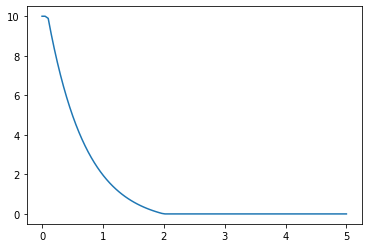

In [19]:
# Visualize proximity reward
shapereward = RewardsShaper(env)
x = np.linspace(0, 5, 100)
y = shapereward.dist_to_reward(x)
plt.plot(x, y)
shapereward.dist_to_reward(0.01)

In [ ]:
# Visualize proximity reward
x = np.linspace(0, 5, 200)
y = np.clip(1 - (x - shapereward.collision_dist)/(shapereward.rdist - shapereward.collision_dist), 0, 1)
plt.plot(x, y)

In [7]:
# Demo environment with hardcoded policies, 3 agents of each class, 2 landmarks
eps = 0.3

def hardcode_policy_1(observation, agent_name):
    """
    Parameters
    ==========
    observation : ndarray
    agent_name : str
    """
    if "adversary" in agent_name:
        # adversary
        if agent_name == "adversary_0":
            return np.random.binomial(2, 0.3) + 3
    elif "agent" in agent_name:
        # non-adversary
        if agent_name == "agent_0":
            pass
    return 0

def hardcode_policy_2(observation, agent_name):
    """
    Parameters
    ==========
    observation : ndarray
    agent : str
    """
    if "adversary" in agent_name:
        # adversary
        if agent_name == "adversary_0":
            # get agent_0's
            x, y = observation[12:14]
            if x < -eps: # go left
                return 1
            elif x > eps: # go right
                return 2
            elif y < -eps: # go down
                return 3
            elif y > eps: # go up
                return 4
            else:
                return random.randint(0, 4)
    elif "agent" in agent_name:
        # non-adversary
        if agent_name == "agent_0":
            return 0
            # return random.randint(0, 4)
    return 0

env.reset()
print(*[landmark.name for landmark in env.world.landmarks])
print(*[agent.name for agent in env.world.agents])
agent_rewards = 0
reshaped_agent_rewards = 0
adversary_rewards = 0
reshaped_adversary_rewards = 0
rewardshaper = RewardsShaper(env)
normalize = Normalizer(env)
for agent_step_idx, agent_name in enumerate(env.agent_iter()):
    env.render()
    observation, reward, done, info = env.last()
    norm_obs = normalize(observation)
    reshaped_reward = rewardshaper(agent_name, observation)
    if done:
        env.step(None)
    else:
        action = hardcode_policy_2(observation, agent_name)
        env.step(action)
        
    if "adversary" in agent_name:
        adversary_rewards += reward
        reshaped_adversary_rewards += reshaped_reward
    elif "agent" in agent_name:
        agent_rewards += reward
        reshaped_agent_rewards += reshaped_reward

    if agent_name == "agent_0":
        # printout assumes 2 landmarks, 3 of each agent class
#         print("obs", np.round(observation, 2))
#         print("obs[vel]", np.round(observation[:2], 2))
#         print("obs[pos]", np.round(observation[2:4], 2))
#         print("obs[landmark1]", np.round(observation[6:8], 2))
#         print("obs[landmark2]", np.round(observation[8:10], 2))
#         print("obs[adversary_0 pos]", np.round(observation[8:10], 2))
#         print("obs[adversary_1 pos]", np.round(observation[10:12], 2))
#         print("obs[agents]", np.round(observation[10:20], 2))
        pass
    elif agent_name == "adversary_0":
#         print(observation.shape)
#         print("obs[agent_0 pos]", np.round(observation[12:14], 2))
#         print("obs[agent_0 pos]", np.round(np.linalg.norm(observation[12:14]), 2))
        print("reward", reward, "reshaped", np.round(reshaped_reward, 2))
        
        pass
    
    # time.sleep(0.1)

print(f"episode ran for {agent_step_idx} steps")
print("agent_rewards", agent_rewards)
print("adversary_rewards", adversary_rewards)

landmark 0 landmark 1
adversary_0 adversary_1 adversary_2 agent_0 agent_1 agent_2
reward 0.0 reshaped 19.11
reward 0.0 reshaped 20.07
reward 0.0 reshaped 21.85
reward 0.0 reshaped 24.42
reward 0.0 reshaped 27.78
reward 0.0 reshaped 31.98
reward 0.0 reshaped 36.34
reward 0.0 reshaped 39.14
reward 0.0 reshaped 40.0
reward 10.0 reshaped 40.0
reward 10.0 reshaped 40.0
reward 0.0 reshaped 40.0
reward 10.0 reshaped 37.73
reward 0.0 reshaped 35.68
reward 0.0 reshaped 34.94
reward 0.0 reshaped 35.1
reward 0.0 reshaped 35.16
reward 0.0 reshaped 35.46
reward 0.0 reshaped 38.98
reward 0.0 reshaped 40.0
reward 0.0 reshaped 40.0
reward 0.0 reshaped 40.0
reward 0.0 reshaped 40.0
reward 0.0 reshaped 40.0
reward 0.0 reshaped 40.0
reward 0.0 reshaped 39.62
reward 0.0 reshaped 38.33
reward 0.0 reshaped 35.96
reward 0.0 reshaped 34.21
reward 0.0 reshaped 34.33
reward 0.0 reshaped 33.5
reward 0.0 reshaped 31.61
reward 0.0 reshaped 29.1
reward 0.0 reshaped 28.43
reward 0.0 reshaped 29.03
reward 0.0 reshape

Help on method randint in module random:

randint(a, b) method of random.Random instance
    Return random integer in range [a, b], including both end points.



In [23]:
def hardcode_policy_1(observation, agent_name):
    """
    Parameters
    ==========
    observation : ndarray
    agent_name : str
    """
    if "adversary" in agent_name:
        # adversary
        if agent_name == "adversary_1":
            return 1
    elif "agent" in agent_name:
        # non-adversary
        if agent_name == "agent_0":
            return 3
    return 0

env.reset()
normalize = Normalizer(env)
agent_rewards = 0
adversary_rewards = 0
for agent_step_idx, agent_name in enumerate(env.agent_iter()):
    env.render()
    observation, reward, done, info = env.last()
    norm_obs = normalize(observation)
    if done:
        env.step(None)
    else:
        action = hardcode_policy_1(observation, agent_name)
        env.step(action)
    if "adversary" in agent_name:
        adversary_rewards += reward
    if "agent" in agent_name:
        agent_rewards += reward
    
    observation = np.round(observation, 2)
    norm_obs = np.round(norm_obs, 2)
    if agent_name == "agent_0":
        # printout assumes 2 landmarks, 3 of each agent class
#         print("obs", np.round(observation, 2))
#         print("obs[vel]", np.round(observation[:2], 2))
#         print("obs[pos]", np.round(observation[2:4], 2))
#         print("obs[landmark1]", np.round(observation[6:8], 2))
#         print("obs[landmark2]", np.round(observation[8:10], 2))
#         print("obs[adversary_0 pos]", observation[8:10], norm_obs[8:10])
#         print("obs[adversary_1 pos]", np.round(observation[10:12], 2), np.round(norm_obs[10:12], 2))
#         print("obs[agents]", np.round(observation[10:20], 2))
        pass
    elif agent_name == "adversary_1":
#         print(observation.shape)
        print("obs[ovels]", observation[18:], norm_obs[18:])
        pass
    # time.sleep(0.1)

print(f"episode ran for {agent_step_idx} steps")
print("agent_rewards", agent_rewards)
print("adversary_rewards", adversary_rewards)

obs[ovels] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.]
obs[ovels] [-0.4 -0.  -0.  -0.   0.   0. ] [-0.31 -0.   -0.   -0.    0.    0.  ]
obs[ovels] [-0.3  0.4 -0.  -0.   0.   0. ] [-0.23  0.31 -0.   -0.    0.    0.  ]
obs[ovels] [ 0.18  0.3  -0.   -0.    0.    0.  ] [ 0.13  0.23 -0.   -0.    0.    0.  ]
obs[ovels] [ 0.13 -0.18 -0.   -0.    0.    0.  ] [ 0.1  -0.13 -0.   -0.    0.    0.  ]
obs[ovels] [ 0.1  -0.13 -0.   -0.    0.    0.  ] [ 0.08 -0.1  -0.   -0.    0.    0.  ]
obs[ovels] [ 0.07 -0.1  -0.   -0.    0.    0.  ] [ 0.06 -0.08 -0.   -0.    0.    0.  ]
obs[ovels] [ 0.06 -0.07 -0.   -0.    0.    0.  ] [ 0.04 -0.06 -0.   -0.    0.    0.  ]
obs[ovels] [ 0.44 -0.06 -0.   -0.    0.    0.  ] [ 0.34 -0.04 -0.   -0.    0.    0.  ]
obs[ovels] [-0.07 -0.04 -0.   -0.    0.    0.  ] [-0.05 -0.03 -0.   -0.    0.    0.  ]
obs[ovels] [-0.05 -0.43 -0.   -0.    0.    0.  ] [-0.04 -0.33 -0.   -0.    0.    0.  ]
obs[ovels] [-0.44 -0.32 -0.   -0.    0.    0.  ] [-0.34 -0.25 -0.   -0.    0.    0.  ]
obs[

In [19]:
class POMDPNormalizer(object):
    def __init__(self, env):
        self.n_landmarks = len(env.world.landmarks)
        self.n_allagents = len(env.world.agents)
        self.n_good = sum(map(lambda a: not a.adversary, env.world.agents))

        # Extra stuff for POMDP
        # distance mask for relative position
        self.d_mask = 0.5
        # value to mask observations
        self.mask_v = 1.5
        self.name_to_idx = {agent.name: i for i, agent in enumerate(env.world.agents)}
        self.idx_to_name = {i: agent.name for i, agent in enumerate(env.world.agents)}
        self.goodagent_indices = [
            i for i, agent in enumerate(env.world.agents) if agent.name.startswith("agent")
        ]
        self.adversary_indices = [
            i for i, agent in enumerate(env.world.agents) if agent.name.startswith("adversary")
        ]
    
    @staticmethod
    def normalize_abs_pos(s):
        """Clip absolute position and scale to [-1, 1]
        s is a scalar or an ndarray of one dimension."""
        return np.clip(s, -1.5, 1.5) / 1.5

    @staticmethod
    def normalize_rel_pos(s):
        """Clip relative position and scale to [-1, 1]
        s is a scalar or an ndarray of one dimension."""
        return np.clip(s, -3, 3) / 3
    
    def normalize_opp_rel_pos(self, s):
        """Clip relative position and scale to [-1, 1]
        s is a scalar or an ndarray of one dimension."""
        return np.clip(s, -self.d_mask, self.d_mask) / self.d_mask

    def __call__(self, obs, agent_name):
        # normalize and clip positions
        norm_obs = obs.copy()
        # normalize velocity of current entity
        norm_obs[:2] = norm_obs[:2] / 1.3
        # clip/scale abs. position of current entity
        norm_obs[2:4] = self.normalize_abs_pos(norm_obs[2:4])
        
        # clip/scale rel. position of landmarks
        for i in range(self.n_landmarks):
            norm_obs[4 + (2*i):4 + (2*(i + 1))] = self.normalize_rel_pos(
                norm_obs[4 + (2*i):4 + (2*(i + 1))]
            )
        # normalize velocity of other entities
        n_range = self.n_landmarks + self.n_allagents - 1
        norm_obs[4 + (2*n_range):] = norm_obs[4 + (2*n_range):] / 1.3

        # Apply POMDP
        agent_idx = self.name_to_idx[agent_name]
        _obs = obs[4 + 2*self.n_landmarks:]
        start_idx = 4 + 2*self.n_landmarks
        vel_start_idx = 4 + 2*(self.n_landmarks + self.n_allagents - 1)
        if agent_name.startswith("agent"):
            # mask observation from far adversary
            for adversary_idx in self.adversary_indices:
                i    = adversary_idx - 1 if agent_idx < adversary_idx else adversary_idx
                x, y = _obs[2*i:2*i + 2]
                d    = math.sqrt(x**2 + y**2)
                if d > self.d_mask:
                    norm_obs[start_idx + 2*i:start_idx + 2*(i + 1)] = self.mask_v
                else:
                    norm_obs[start_idx + 2*i:start_idx + 2*(i + 1)] = self.normalize_opp_rel_pos(
                        norm_obs[start_idx + 2*i:start_idx + 2*(i + 1)]
                    )
            for goodagent_idx in self.goodagent_indices:
                if goodagent_idx == agent_idx:
                    continue
                i    = goodagent_idx - 1 if agent_idx < goodagent_idx else goodagent_idx
                norm_obs[start_idx + 2*i:start_idx + 2*(i + 1)] = self.normalize_rel_pos(
                    norm_obs[start_idx + 2*i:start_idx + 2*(i + 1)]
                )
        else:
            # agent_name.startswith("adversary")
            # mask observation from far agent
            for adversary_idx in self.adversary_indices:
                if adversary_idx == agent_idx:
                    continue
                i    = adversary_idx - 1 if agent_idx < adversary_idx else adversary_idx
                norm_obs[start_idx + 2*i:start_idx + 2*(i + 1)] = self.normalize_rel_pos(
                    norm_obs[start_idx + 2*i:start_idx + 2*(i + 1)]
                )
            for vel_i, goodagent_idx in enumerate(self.goodagent_indices):
                i    = goodagent_idx - 1 if agent_idx < goodagent_idx else goodagent_idx
                x, y = _obs[2*i:2*i + 2]
                d    = math.sqrt(x**2 + y**2)
                if d > self.d_mask:
                    # 
                    norm_obs[start_idx + 2*i:start_idx + 2*(i + 1)] = self.mask_v
                    norm_obs[vel_start_idx + 2*vel_i:vel_start_idx + 2*(vel_i + 1)] = self.mask_v
                else:
                    norm_obs[start_idx + 2*i:start_idx + 2*(i + 1)] = self.normalize_opp_rel_pos(
                        norm_obs[start_idx + 2*i:start_idx + 2*(i + 1)]
                    )

        return norm_obs

In [20]:
print(*[landmark.name for landmark in env.world.landmarks])
print(*[agent.name for agent in env.world.agents])

landmark 0 landmark 1
adversary_0 adversary_1 adversary_2 agent_0 agent_1 agent_2


In [35]:
# test that POMDPNormalizer works for adversary
env.reset()
normalize = POMDPNormalizer(env)
agent_name = "adversary_0"
obs = np.array([
    0,0, # velocity
    0.5,0.5, # position
    0,0,0,0, # position of landmark
    0,0, # adversary_1
    0,0, # adversary_2
    0,0, # agent_0
    0.3,0.4, # agent_1
    0,0, # agent_2
    1,0.2, # agent_0 vel
    0,0, # agent_1 vel
    0,0, # agent_2 vel
])
normalize(obs, agent_name)

array([0.        , 0.        , 0.33333333, 0.33333333, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.6       ,
       0.8       , 0.        , 0.        , 0.76923077, 0.15384615,
       0.        , 0.        , 0.        , 0.        ])

In [41]:
# test that POMDPNormalizer works for agent
env.reset()
normalize = POMDPNormalizer(env)
agent_name = "agent_0"
obs = np.array([
    0,0, # velocity
    0.5,0.5, # position
    0,0,0,0, # position of landmark
    0,0, # adversary_0
    0.3,0.4, # adversary_1
    0,0, # adversary_2
    0,0, # agent_1
    0,0, # agent_2
    0,0, # agent_1 vel
    0,0, # agent_2 vel
])
normalize(obs, agent_name)

array([0.        , 0.        , 0.33333333, 0.33333333, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.6       , 0.8       , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [25]:
x, y = 0.3, 0.4
math.sqrt(x**2 + y**2)

0.5

In [94]:
# Try masking values with POMDPNormalizer



def hardcode_policy_3(observation, agent_name):
    """
    Parameters
    ==========
    observation : ndarray
    agent_name : str
    """
    # adversary
    if agent_name == "adversary_0":
        return 1
        pass
    # non-adversary
    if agent_name == "agent_0":
#         return random.randint(0, 4)
#         return 2
        pass
    if "agent" in agent_name:
        return random.randint(0, 4)
    return 0

env.close()
env.reset()
print(*[landmark.name for landmark in env.world.landmarks])
print(*[agent.name for agent in env.world.agents])
print("start index of adversary pos", 4 + 2*2)
print("for adversary: start index of agent pos", 4 + 2*2 + 2*2)
print("for agent: start index of agent pos", 4 + 2*3 + 2*2)
print("start index of vel", 4 + 2*(2 + 5))
agent_rewards = 0
adversary_rewards = 0
normalize = POMDPNormalizer(env)
for agent_step_idx, agent_name in enumerate(env.agent_iter()):
    env.render()
    observation, reward, done, info = env.last()
    norm_obs = normalize(observation, agent_name)
    if done:
        env.step(None)
    else:
        action = hardcode_policy_3(observation, agent_name)
        env.step(action)

    observation = np.round(observation, 2)
    norm_obs    = np.round(norm_obs, 2)
    if agent_name == "agent_0":
        
        # printout assumes 2 landmarks, 3 of each agent class
#         print("obs[vel]", observation[:2], norm_obs[:2])
#         print("obs[vel]", observation[:2], norm_obs[:2])
        
#         print("obs[vel]", np.round(observation[:2], 2))
#         print("obs[pos]", np.round(observation[2:4], 2))
#         print("obs[landmark1]", np.round(observation[6:8], 2))
#         print("obs[landmark2]", np.round(observation[8:10], 2))
#         print("obs[adversary_0 pos]", np.round(observation[8:10], 2))
#         print("obs[adversary_1 pos]", np.round(observation[10:12], 2))
#         print("obs[agents]", np.round(observation[10:20], 2))
#         print("obs[adversary pos]", observation[8:14], norm_obs[8:14])
#         print("obs[agent pos]", observation[14:18], norm_obs[14:18])
#         print("obs[ovels]", observation[18:], norm_obs[18:])
        pass
    elif agent_name == "adversary_0":
        # print(observation.shape)
        # print("obs[agent_0 pos]", np.round(observation[12:14], 2))
#         print("obs[agent_0 pos]", np.round(np.linalg.norm(observation[12:14]), 2))

#         print("obs[adversary pos]", observation[8:12], norm_obs[8:12])
        # print("obs[agent pos]", observation[12:18], norm_obs[12:18])
        print("obs[ovels]", observation[18:], norm_obs[18:])
        pass
    
    time.sleep(0.005)

    

landmark 0 landmark 1
adversary_0 adversary_1 adversary_2 agent_0 agent_1 agent_2
start index of adversary pos 8
for adversary: start index of agent pos 12
for agent: start index of agent pos 14
start index of vel 18
obs[ovels] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.]
obs[ovels] [ 0.   0.4  0.  -0.  -0.  -0.4] [0. 0. 0. 0. 0. 0.]
obs[ovels] [ 0.   0.7  0.  -0.  -0.   0.1] [0. 0. 0. 0. 0. 0.]
obs[ovels] [ 0.    0.92  0.   -0.4  -0.    0.08] [0. 0. 0. 0. 0. 0.]
obs[ovels] [ 0.    0.29  0.4  -0.3  -0.4   0.06] [0. 0. 0. 0. 0. 0.]
obs[ovels] [ 0.    0.22  0.3  -0.62  0.1   0.04] [0. 0. 0. 0. 0. 0.]
obs[ovels] [ 0.   -0.23  0.22 -0.47  0.48  0.03] [0. 0. 0. 0. 0. 0.]
obs[ovels] [ 0.   -0.18  0.17 -0.35  0.36 -0.38] [0. 0. 0. 0. 0. 0.]
obs[ovels] [-0.4  -0.13  0.13  0.14 -0.13 -0.28] [0. 0. 0. 0. 0. 0.]
obs[ovels] [ 0.1  -0.1   0.09  0.1   0.3  -0.21] [0. 0. 0. 0. 0. 0.]
obs[ovels] [ 0.08 -0.07  0.47  0.08  0.63 -0.16] [0. 0. 0. 0. 0. 0.]
obs[ovels] [ 0.46 -0.06  0.35  0.46  0.47  0.28] [0. 0

### How to train the agents?

- Use the differental inter-agent learning (DIAL) algorithm.
- Use parameter sharing for DAIL agents. Separate parameter sets for adversary agents and good agents.
- It's not entirely clear the authors accumulate gradients for differentiable communication, but it 

Messages are vectors. Length 4, 5 should work.

Concatenate the messages from all the actors and add them to the message input for the current agent.

The names of agents are: 
adversary_0 adversary_1 adversary_2 agent_0 agent_1 agent_2

### Test one agent of each class, 1 landmark

In [79]:
env.close()

In [22]:
env = simple_tag_v2.env(
    num_good=1,
    num_adversaries=1,
    num_obstacles=1,
    max_cycles=300,
    continuous_actions=False
).unwrapped
print("Peek into unwrapped environment:", *dir(env))

Peek into unwrapped environment: __class__ __delattr__ __dict__ __dir__ __doc__ __eq__ __format__ __ge__ __getattribute__ __gt__ __hash__ __init__ __init_subclass__ __le__ __lt__ __module__ __ne__ __new__ __reduce__ __reduce_ex__ __repr__ __setattr__ __sizeof__ __str__ __subclasshook__ __weakref__ _accumulate_rewards _agent_selector _clear_rewards _dones_step_first _execute_world_step _index_map _reset_render _set_action _was_done_step action_space action_spaces agent_iter agents close continuous_actions current_actions last local_ratio max_cycles max_num_agents metadata np_random num_agents observation_space observation_spaces observe possible_agents render reset scenario seed state state_space step steps unwrapped viewer world


In [24]:
# Demo environment with hardcoded policies, 1 agent of each class, no landmarks
eps = 0.3
def hardcode_policy_2(observation, agent_name):
    """
    Parameters
    ==========
    observation : ndarray
    agent : str
    """
    if "adversary" in agent_name:
        # adversary
        if agent_name == "adversary_0":
            # get agent_0's
            x, y = observation[6:8]
            if x < -eps: # go left
                return 1
            elif x > eps: # go right
                return 2
            elif y < -eps: # go down
                return 3
            elif y > eps: # go up
                return 4
            else:
                return random.randint(0, 4)
    elif "agent" in agent_name:
        # non-adversary
        if agent_name == "agent_0":
            return 0
            # return random.randint(0, 4)
    return 0

env.reset()
print(*[landmark.name for landmark in env.world.landmarks])
print(*[agent.name for agent in env.world.agents])
agent_rewards = 0
reshaped_agent_rewards = 0
adversary_rewards = 0
reshaped_adversary_rewards = 0
rewardshaper = RewardsShaper(env)
normalize = Normalizer(env)
for agent_step_idx, agent_name in enumerate(env.agent_iter()):
    env.render()
    observation, reward, done, info = env.last()
    reshaped_reward = rewardshaper(agent_name, observation)
#     norm_obs = normalize(observation)
    if done:
        env.step(None)
    else:
        action = hardcode_policy_2(observation, agent_name)
        env.step(action)
        
    if "adversary" in agent_name:
        adversary_rewards += reward
        reshaped_adversary_rewards += reshaped_reward
    elif "agent" in agent_name:
        agent_rewards += reward
        reshaped_agent_rewards += reshaped_reward

    if agent_name == "agent_0":
        # printout assumes 2 landmarks, 3 of each agent class
#         print("obs", np.round(observation, 2))
#         print("obs[vel]", np.round(observation[:2], 2))
#         print("obs[pos]", np.round(observation[2:4], 2))
#         print("obs[landmark1]", np.round(observation[6:8], 2))
#         print("obs[landmark2]", np.round(observation[8:10], 2))
#         print("obs[adversary_0 pos]", np.round(observation[8:10], 2))
#         print("obs[adversary_1 pos]", np.round(observation[10:12], 2))
#         print("obs[agents]", np.round(observation[10:20], 2))
#         print("reward", np.round(reward, 2), "reshaped", np.round(reshaped_reward, 2))
        pass
    elif agent_name == "adversary_0":
#         print(observation.shape)
#         print("obs[agent_0 pos]", np.round(observation[12:14], 2))
#         print("obs[agent_0 pos]", np.round(np.linalg.norm(observation[12:14]), 2))
        print("reward", reward, "reshaped", np.round(reshaped_reward, 2))
        pass
    
    # time.sleep(0.1)

print(f"episode ran for {agent_step_idx} steps")
print("agent_rewards", agent_rewards)
print("adversary_rewards", adversary_rewards)

landmark 0
adversary_0 agent_0
reward 0.0 reshaped 1.59
reward 0.0 reshaped 1.57
reward 0.0 reshaped 1.51
reward 0.0 reshaped 1.5
reward 0.0 reshaped 1.53
reward 0.0 reshaped 1.61
reward 0.0 reshaped 1.7
reward 0.0 reshaped 1.82
reward 0.0 reshaped 1.96
reward 0.0 reshaped 2.2
reward 0.0 reshaped 2.51
reward 0.0 reshaped 2.82
reward 0.0 reshaped 3.24
reward 0.0 reshaped 3.78
reward 0.0 reshaped 4.45
reward 0.0 reshaped 5.27
reward 0.0 reshaped 6.21
reward 0.0 reshaped 7.22
reward 0.0 reshaped 8.2
reward 0.0 reshaped 8.76
reward 0.0 reshaped 8.9
reward 0.0 reshaped 8.95
reward 0.0 reshaped 8.65
reward 0.0 reshaped 7.95
reward 0.0 reshaped 7.34
reward 0.0 reshaped 6.88
reward 0.0 reshaped 6.38
reward 0.0 reshaped 6.29
reward 0.0 reshaped 6.47
reward 0.0 reshaped 6.82
reward 0.0 reshaped 6.85
reward 0.0 reshaped 6.86
reward 0.0 reshaped 7.07
reward 0.0 reshaped 7.2
reward 0.0 reshaped 7.27
reward 0.0 reshaped 7.42
reward 0.0 reshaped 7.86
reward 0.0 reshaped 8.6
reward 0.0 reshaped 9.16
r

In [25]:
def hardcode_policy_3(observation, agent_name):
    """
    Parameters
    ==========
    observation : ndarray
    agent_name : str
    """
    if "adversary" in agent_name:
        # adversary
        if agent_name == "adversary_0":
            pass
    elif "agent" in agent_name:
        # non-adversary
        if agent_name == "agent_0":
            return 3
    return 0

env.reset()
normalize = Normalizer(env)
agent_rewards = 0
adversary_rewards = 0
for agent_step_idx, agent_name in enumerate(env.agent_iter()):
    # env.render()
    observation, reward, done, info = env.last()
    norm_obs = normalize(observation)
    if done:
        env.step(None)
    else:
        action = hardcode_policy_3(observation, agent_name)
        env.step(action)
    if "adversary" in agent_name:
        adversary_rewards += reward
    if "agent" in agent_name:
        agent_rewards += reward
    
    if agent_name == "agent_0":
        # printout assumes 2 landmarks, 3 of each agent class
#         print("obs", np.round(observation, 2))
#         print("obs[vel]", np.round(observation[:2], 2), "obs[vel]", np.round(norm_obs[:2], 2))
#         print("obs[pos]", np.round(observation[2:4], 2), "obs[pos]", np.round(norm_obs[2:4], 2))
#         print("obs[landmark1]", np.round(observation[4:6], 2), "obs[landmark1]", np.round(norm_obs[4:6], 2))
#         print("obs[oagents]", np.round(observation[6:8], 2), "obs[oagents]", np.round(norm_obs[6:8], 2))
#         print("obs[ovels]", np.round(observation[8:], 2), "obs[ovels]", np.round(norm_obs[8:], 2))
        pass
    elif agent_name == "adversary_0":
#         print(observation.shape)
        print("obs[ovels]", np.round(observation[8:], 2), "obs[ovels]", np.round(norm_obs[8:], 2))
        pass
    # time.sleep(0.1)

print(f"episode ran for {agent_step_idx} steps")
print("agent_rewards", agent_rewards)
print("adversary_rewards", adversary_rewards)

obs[ovels] [0. 0.] obs[ovels] [0. 0.]
obs[ovels] [ 0.  -0.4] obs[ovels] [ 0.   -0.31]
obs[ovels] [ 0.  -0.7] obs[ovels] [ 0.   -0.54]
obs[ovels] [ 0.   -0.92] obs[ovels] [ 0.   -0.71]
obs[ovels] [ 0.   -1.09] obs[ovels] [ 0.   -0.84]
obs[ovels] [ 0.   -1.22] obs[ovels] [ 0.   -0.94]
obs[ovels] [ 0.  -1.3] obs[ovels] [ 0. -1.]
obs[ovels] [ 0.  -1.3] obs[ovels] [ 0. -1.]
obs[ovels] [ 0.  -1.3] obs[ovels] [ 0. -1.]
obs[ovels] [ 0.  -1.3] obs[ovels] [ 0. -1.]
obs[ovels] [ 0.  -1.3] obs[ovels] [ 0. -1.]
obs[ovels] [ 0.  -1.3] obs[ovels] [ 0. -1.]
obs[ovels] [ 0.07 -1.27] obs[ovels] [ 0.06 -0.98]
obs[ovels] [ 0.39 -1.24] obs[ovels] [ 0.3  -0.96]
obs[ovels] [ 0.28 -1.27] obs[ovels] [ 0.21 -0.98]
obs[ovels] [ 0.2  -1.29] obs[ovels] [ 0.15 -0.99]
obs[ovels] [ 0.14 -1.29] obs[ovels] [ 0.11 -0.99]
obs[ovels] [ 0.1 -1.3] obs[ovels] [ 0.08 -1.  ]
obs[ovels] [ 0.07 -1.3 ] obs[ovels] [ 0.05 -1.  ]
obs[ovels] [ 0.05 -1.3 ] obs[ovels] [ 0.04 -1.  ]
obs[ovels] [ 0.04 -1.3 ] obs[ovels] [ 0.03 -1.  ]
obs[

obs[ovels] [ 0.  -1.3] obs[ovels] [ 0. -1.]
obs[ovels] [ 0.  -1.3] obs[ovels] [ 0. -1.]
obs[ovels] [ 0.  -1.3] obs[ovels] [ 0. -1.]
obs[ovels] [ 0.  -1.3] obs[ovels] [ 0. -1.]
obs[ovels] [ 0.  -1.3] obs[ovels] [ 0. -1.]
obs[ovels] [ 0.  -1.3] obs[ovels] [ 0. -1.]
obs[ovels] [ 0.  -1.3] obs[ovels] [ 0. -1.]
obs[ovels] [ 0.  -1.3] obs[ovels] [ 0. -1.]
obs[ovels] [ 0.  -1.3] obs[ovels] [ 0. -1.]
obs[ovels] [ 0.  -1.3] obs[ovels] [ 0. -1.]
obs[ovels] [ 0.  -1.3] obs[ovels] [ 0. -1.]
obs[ovels] [ 0.  -1.3] obs[ovels] [ 0. -1.]
obs[ovels] [ 0.  -1.3] obs[ovels] [ 0. -1.]
obs[ovels] [ 0.  -1.3] obs[ovels] [ 0. -1.]
obs[ovels] [ 0.  -1.3] obs[ovels] [ 0. -1.]
obs[ovels] [ 0.  -1.3] obs[ovels] [ 0. -1.]
obs[ovels] [ 0.  -1.3] obs[ovels] [ 0. -1.]
obs[ovels] [ 0.  -1.3] obs[ovels] [ 0. -1.]
obs[ovels] [ 0.  -1.3] obs[ovels] [ 0. -1.]
obs[ovels] [ 0.  -1.3] obs[ovels] [ 0. -1.]
obs[ovels] [ 0.  -1.3] obs[ovels] [ 0. -1.]
obs[ovels] [ 0.  -1.3] obs[ovels] [ 0. -1.]
obs[ovels] [ 0.  -1.3] obs[ovels

### Visualize physics

In [8]:
env.close()

In [16]:
env = simple_tag_v2.env(
    num_good=1,
    num_adversaries=1,
    num_obstacles=0,
    max_cycles=10,
    continuous_actions=False
).unwrapped
print("Peek into unwrapped environment:", *dir(env))

Peek into unwrapped environment: __class__ __delattr__ __dict__ __dir__ __doc__ __eq__ __format__ __ge__ __getattribute__ __gt__ __hash__ __init__ __init_subclass__ __le__ __lt__ __module__ __ne__ __new__ __reduce__ __reduce_ex__ __repr__ __setattr__ __sizeof__ __str__ __subclasshook__ __weakref__ _accumulate_rewards _agent_selector _clear_rewards _dones_step_first _execute_world_step _index_map _reset_render _set_action _was_done_step action_space action_spaces agent_iter agents close continuous_actions current_actions last local_ratio max_cycles max_num_agents metadata np_random num_agents observation_space observation_spaces observe possible_agents render reset scenario seed state state_space step steps unwrapped viewer world


In [28]:
def hardcode_policy_4(step_idx, observation, agent_name):
    """
    Parameters
    ==========
    observation : ndarray
    agent_name : str
    """
    
    if agent_name == "adversary_0":
        if step_idx == 10 or step_idx == 11 or step_idx == 12 or step_idx == 13:
            return 2
        elif step_idx == 14 or step_idx == 15 or step_idx == 16:
            return 1
        else:
            return 0
    else:
        return 0

env.reset()
# normalize = Normalizer(env)
for agent_step_idx, agent_name in enumerate(env.agent_iter()):
    step_idx = agent_step_idx // 2
    env.render()
    observation, reward, done, info = env.last()
#     norm_obs = normalize(observation)
    if done:
        env.step(None)
    else:
        action = hardcode_policy_4(step_idx, observation, agent_name)
        env.step(action)
    
    observation = np.round(observation, 2)
    if agent_name == "agent_0":
        pass
    elif agent_name == "adversary_0":
#         print(observation.shape)
        print("step", step_idx, "obs[pos]", observation[2:4], "obs[vel]", observation[0:2])
    # time.sleep(0.1)

step 0 obs[pos] [-0.66 -0.9 ] obs[vel] [0. 0.]
step 1 obs[pos] [-0.66 -0.9 ] obs[vel] [0. 0.]
step 2 obs[pos] [-0.66 -0.9 ] obs[vel] [0. 0.]
step 3 obs[pos] [-0.66 -0.9 ] obs[vel] [0. 0.]
step 4 obs[pos] [-0.66 -0.9 ] obs[vel] [0. 0.]
step 5 obs[pos] [-0.66 -0.9 ] obs[vel] [0. 0.]
step 6 obs[pos] [-0.66 -0.9 ] obs[vel] [0. 0.]
step 7 obs[pos] [-0.66 -0.9 ] obs[vel] [0. 0.]
step 8 obs[pos] [-0.66 -0.9 ] obs[vel] [0. 0.]
step 9 obs[pos] [-0.66 -0.9 ] obs[vel] [0. 0.]
step 10 obs[pos] [-0.66 -0.9 ] obs[vel] [0. 0.]
step 11 obs[pos] [-0.63 -0.9 ] obs[vel] [0.3 0. ]
step 12 obs[pos] [-0.57 -0.9 ] obs[vel] [0.52 0.  ]
step 13 obs[pos] [-0.5 -0.9] obs[vel] [0.69 0.  ]
step 14 obs[pos] [-0.42 -0.9 ] obs[vel] [0.82 0.  ]
step 15 obs[pos] [-0.39 -0.9 ] obs[vel] [0.32 0.  ]
step 16 obs[pos] [-0.4 -0.9] obs[vel] [-0.06  0.  ]
step 17 obs[pos] [-0.43 -0.9 ] obs[vel] [-0.35  0.  ]
step 18 obs[pos] [-0.46 -0.9 ] obs[vel] [-0.26  0.  ]
step 19 obs[pos] [-0.48 -0.9 ] obs[vel] [-0.2  0. ]
step 20 obs[po

In [21]:

def hardcode_policy_5(step_idx, observation, agent_name):
    """
    Parameters
    ==========
    observation : ndarray
    agent_name : str
    """
    
    if agent_name == "adversary_0":
        return 1
    else:
        return 2

env.close()
env.reset()
print(*[landmark.name for landmark in env.world.landmarks])
print(*[agent.name for agent in env.world.agents])
for agent_step_idx, agent_name in enumerate(env.agent_iter()):
    step_idx = agent_step_idx // 2
    env.render()
    observation, reward, done, info = env.last()
    if done:
        env.step(None)
    else:
        action = hardcode_policy_5(step_idx, observation, agent_name)
        env.step(action)
    
    observation = np.round(observation, 2)
    print("step", step_idx, "agent", agent_name)
    if agent_name == "agent_0":
        print("obs[agent pos]", observation[2:4], "obs[adversary pos]", observation[2:4] + observation[4:6])
        pass
    elif agent_name == "adversary_0":
#         print(observation.shape)
        print("obs[agent pos]", observation[2:4] + observation[4:6], "obs[adversary pos]", observation[2:4])
        pass
    time.sleep(0.01)


adversary_0 agent_0
step 0 agent adversary_0
obs[agent pos] [ 0.79       -0.40000004] obs[adversary pos] [ 0.46 -0.91]
step 0 agent agent_0
obs[agent pos] [ 0.79 -0.39] obs[adversary pos] [ 0.46 -0.9 ]
step 1 agent adversary_0
obs[agent pos] [ 0.83000004 -0.40000004] obs[adversary pos] [ 0.43 -0.91]
step 1 agent agent_0
obs[agent pos] [ 0.83 -0.39] obs[adversary pos] [ 0.42999998 -0.9       ]
step 2 agent adversary_0
obs[agent pos] [ 0.9        -0.40000004] obs[adversary pos] [ 0.38 -0.91]
step 2 agent agent_0
obs[agent pos] [ 0.9  -0.39] obs[adversary pos] [ 0.38 -0.9 ]
step 3 agent adversary_0
obs[agent pos] [ 0.99       -0.40000004] obs[adversary pos] [ 0.31 -0.91]
step 3 agent agent_0
obs[agent pos] [ 0.99 -0.39] obs[adversary pos] [ 0.31 -0.9 ]
step 4 agent adversary_0
obs[agent pos] [ 1.1        -0.40000004] obs[adversary pos] [ 0.23 -0.91]
step 4 agent agent_0
obs[agent pos] [ 1.1  -0.39] obs[adversary pos] [ 0.23000002 -0.9       ]
step 5 agent adversary_0
obs[agent pos] [ 1.2